In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical hp prices
In this notebook, you will load historical hp price data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:

hp = pd.read_csv(
    Path("hp.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)

hp.head()

,Close,Volume,Open,High,Low
Date,,,,,
2014-12-17,17.88,11527190.0,17.59,17.93,17.53
2014-12-18,18.42,12415970.0,18.08,18.43,18.02
2014-12-19,18.46,18558860.0,18.40,18.62,18.35
2014-12-22,18.41,10806910.0,18.49,18.69,18.28
2014-12-23,18.67,9664837.0,18.47,18.78,18.47


In [3]:
# Trim the dataset to begin on December 15th, 2015
hp = hp.loc["2014-12-15":, :]
hp.head(500)


,Close,Volume,Open,High,Low
Date,,,,,
2014-12-17,17.88,11527190.0,17.59,17.93,17.53
2014-12-18,18.42,12415970.0,18.08,18.43,18.02
2014-12-19,18.46,18558860.0,18.40,18.62,18.35
2014-12-22,18.41,10806910.0,18.49,18.69,18.28
2014-12-23,18.67,9664837.0,18.47,18.78,18.47
...,...,...,...,...,...
2016-12-05,15.55,11538520.0,15.26,15.55,15.26
2016-12-06,15.60,6886889.0,15.51,15.64,15.46
2016-12-07,16.15,11679160.0,15.62,16.17,15.60


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Close/Last" price. Do you see any patterns, long-term and/or short?

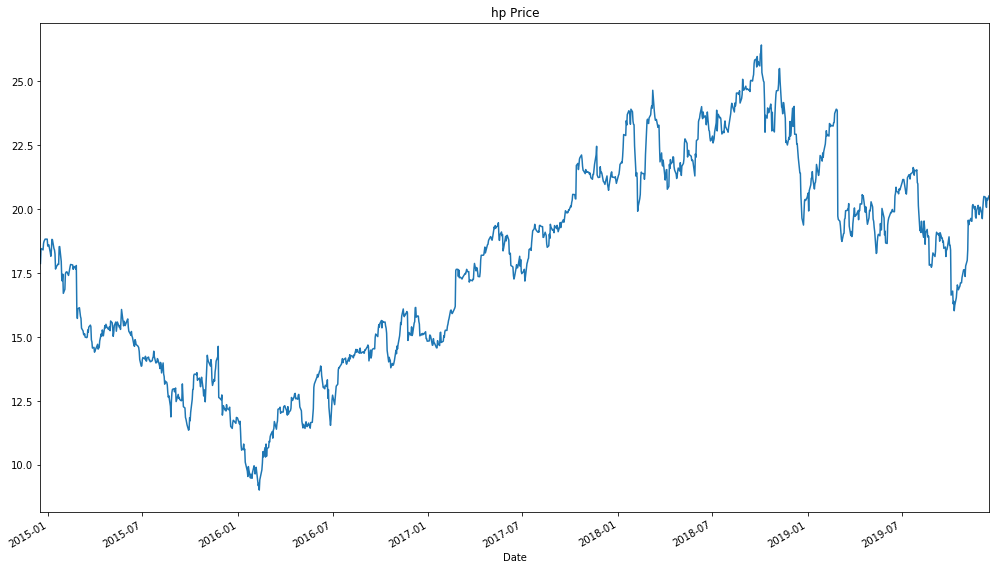

In [4]:
# Plot just the "Close/Last" column from the dataframe:
hp['Close'].plot(figsize=(17, 10), title="hp Price")

*Answer*
 * Based on the plot above, we can see a long-term strengthening of the hp prices. There do seem to be some more medium, 1-3 year consistent trends, but on a daily basis, there are a lot of short-term ups and downs.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Close" price into two separate series:
hp_noise, hp_trend = sm.tsa.filters.hpfilter(hp['Close'])

In [6]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
hp_decomp = hp[["Close"]].copy()
hp_decomp["noise"] = hp_noise
hp_decomp["trend"] = hp_trend
hp_decomp.head()

,Close,noise,trend
Date,,,
2014-12-17,17.88,-0.680607,18.560607
2014-12-18,18.42,-0.141113,18.561113
2014-12-19,18.46,-0.101192,18.561192
2014-12-22,18.41,-0.150333,18.560333
2014-12-23,18.67,0.112042,18.557958


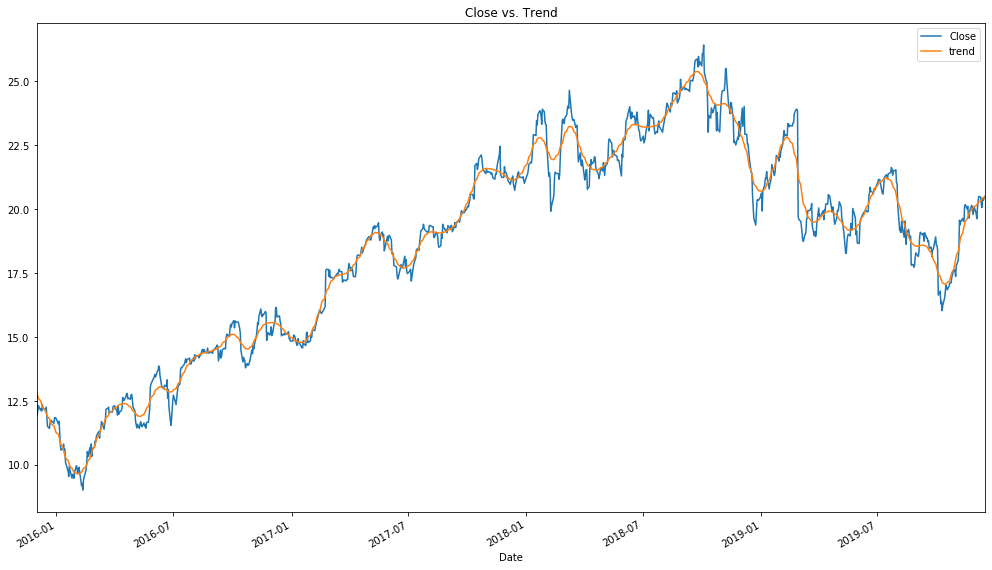

In [7]:
# Plot the Settle Price vs. the Trend
hp_decomp[["Close", "trend"]]["2015-12-01":].plot(figsize=(17, 10), title="Close vs. Trend")

Smoothing with the HP Filter and plotting the resulting trend against the actual futures returns, we can see that there's a lot of short term fluctuations that deviate around this trend. Perhaps these would represent profitable trading opportunities: For example, when the blue line deviates far below the orange, we can see this as a sign that the Yen is temporarily more undervalued than it should be (and, therefore, we'd see this as a short-term buying opportunity).

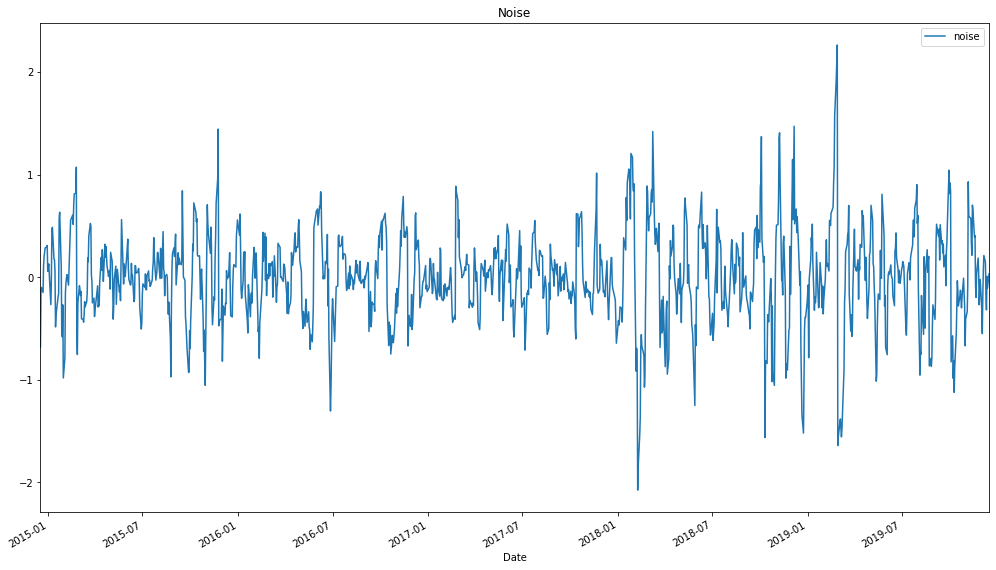

In [8]:
# Plot the Settle Noise
hp_decomp[["noise"]].plot(figsize=(17, 10), title="Noise")

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Close" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (hp[["Close"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Close
Date,
2019-12-10,-1.319003
2019-12-11,-0.643564
2019-12-12,1.793722
2019-12-13,-0.391581
2019-12-16,0.835381


In [10]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

In [11]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1257
Model:                     ARMA(2, 1)   Log Likelihood               -2554.205
Method:                       css-mle   S.D. of innovations              1.846
Date:                Wed, 18 Dec 2019   AIC                           5118.409
Time:                        20:53:22   BIC                           5144.092
Sample:                             0   HQIC                          5128.062
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0284      0.054      0.524      0.600      -0.078       0.135
ar.L1.y        0.4892      0.424      1.154      0.249      -0.342       1.320
ar.L2.y        0.0235      0.029      0.823      0.411      -0.033       0.080
ma.L1.y       -0.4926      0.423     -1.163      0.245      -1.322       0.337
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8749           +0.0000j            1.8749            0.0000
AR.2          -22.6595           +0.0000j           22.6595            0.5000
MA.1            2.0302           +0.0000j            2.0302            0.0000
-----------------------------------------------------------------------------
"""

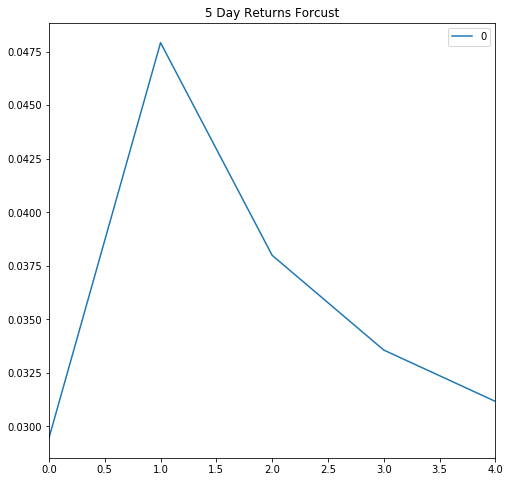

In [12]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(figsize=(8, 8), title="5 Day Returns Forcust")

## Question:

#### Based on the p-value, is the model a good fit?

## Answer:

#### Based on the p-value, the model is not a good fit.

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [13]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(hp["Close"], order=(5, 1, 1))


# Fit the model
results = model.fit()

C:\Users\armen\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\armen\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [14]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1257
Model:                 ARIMA(5, 1, 1)   Log Likelihood                -382.624
Method:                       css-mle   S.D. of innovations              0.328
Date:                Wed, 18 Dec 2019   AIC                            781.247
Time:                        20:53:31   BIC                            822.339
Sample:                             1   HQIC                           796.691
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0021      0.009      0.224      0.823      -0.016       0.021
ar.L1.D.Close    -0.3407      0.304     -1.120      0.263      -0.937       0.256
ar.L2.D.Close     0.0134      0.030      0.450      0.653      -0.045       0.072
ar.L3.D.Close     0.0405      0.030      1.352      0.177      -0.018       0.099
ar.L4.D.Close     0.0263      0.032      0.830      0.407      -0.036       0.088
ar.L5.D.Close    -0.0506      0.030     -1.676      0.094      -0.110       0.009
ma.L1.D.Close     0.3387      0.304      1.114      0.265      -0.257       0.934
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5430           -0.0000j            1.5430           -0.5000
AR.2           -0.7082           -1.5549j            1.7086           -0.3180
AR.3           -0.7082           +1.5549j            1.7086            0.3180
AR.4            1.7394           -1.1677j            2.0951           -0.0941
AR.5            1.7394           +1.1677j            2.0951            0.0941
MA.1           -2.9525           +0.0000j            2.9525            0.5000
-----------------------------------------------------------------------------
"""

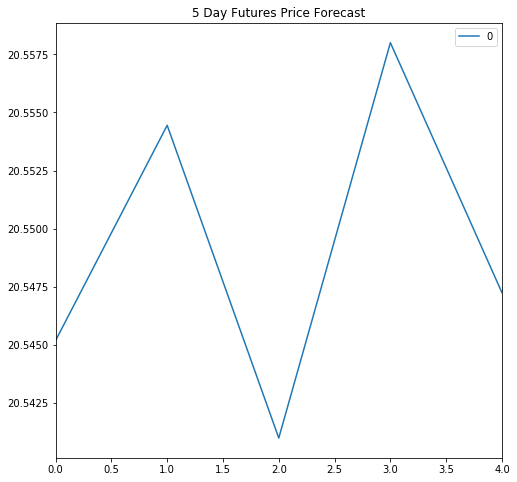

In [15]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(figsize=(8, 8), title="5 Day Futures Price Forecast")

### What does the model forecast will happen to the hp price in the near term?

### Based on model forcast the hp stock price will go down in value

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [16]:
import arch as arch
from arch import arch_model

In [17]:
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1, rescale=False)

# Fit the model
res = model.fit(disp="off")

In [18]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2539.40
Distribution:                  Normal   AIC:                           5086.80
Method:            Maximum Likelihood   BIC:                           5107.35
                                        No. Observations:                 1257
Date:                Wed, Dec 18 2019   Df Residuals:                     1253
Time:                        20:53:36   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0439  2.509e-02      1.751  7.997e-02 [-5.246e-03,9.309e-02]
alpha[1]       0.0128  6.746e-02      0.190      0.849      [ -0.119,  0.145]
alpha[2]       0.0000  6.581e-02      0.000      1.000      [ -0.129,  0.129]
beta[1]        0.9745  1.155e-02     84.383      0.000      [  0.952,  0.997]
=============================================================================

Covariance estimator: robust
"""

In [19]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-12-16'

In [24]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = res.forecast(start=last_day, horizon=forecast_horizon)
forecasts

In [25]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.tail()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-12-16,28.649787,28.661387,28.672836,28.684135,28.695286


In [26]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-12-16
h.1,28.649787
h.2,28.661387
h.3,28.672836
h.4,28.684135
h.5,28.695286


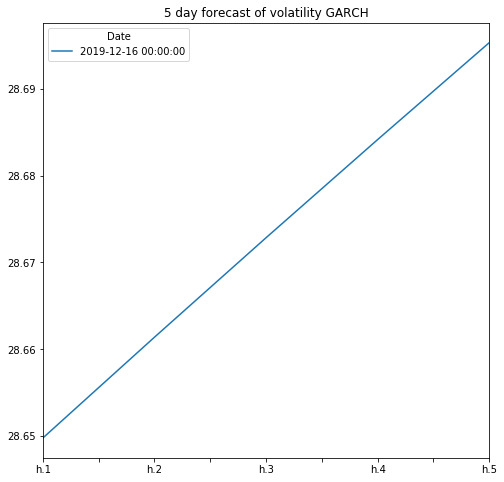

In [27]:
# Plot the final forecast
final.plot(figsize=(8, 8), title="5 day forecast of volatility GARCH")

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

2. Is the risk of the yen expected to increase or decrease?

3. Based on the model evaluation, would you feel confident in using these models for trading?

1. Based on time series analysis I would by the yen now.

2. Yes, the risk expected to increase.

3. Based on the model evaluation, I feel confident uding only GARCH model for trading. ARMA and ARIMA are not good fit.